# Complete Workflow: Linear Discriminant Analysis (LDA) 

This notebook demonstrates the complete application of LDA, covering both of its primary uses:

1.  **Dimensionality Reduction for Visualization**: We first apply LDA to the entire dataset to visually inspect how well it separates the classes in a lower-dimensional space.
2.  **Preprocessing for Classification**: We then use LDA in a proper machine learning pipeline, including a train-test split, to train a classifier and evaluate its performance on unseen data.


## Part 1: LDA Implementation from Scratch

### 1.1 Import Core Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

### 1.2 The LDA Class

This class encapsulates the mathematics of LDA: calculating scatter matrices ($S_W$, $S_B$), solving the eigenvalue problem for $S_W^{-1}S_B$, and projecting the data.

In [12]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))

        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            SW += (X_c - mean_c).T.dot(X_c - mean_c)
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        A = np.linalg.inv(SW).dot(SB)
        eigenvalues, eigenvectors = np.linalg.eig(A)
        
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvectors = eigenvectors[idxs]
        
        self.linear_discriminants = eigenvectors[0:self.n_components]

    def transform(self, X):
        return np.dot(X, self.linear_discriminants.T)
        
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

## Part 2: LDA for Exploratory Visualization 

Here, we apply LDA to the **entire dataset**. The goal is to create a 2D scatter plot to see if the classes are linearly separable in the new feature space created by LDA. This is a common exploratory step.

### 2.1 Load and Prepare Data

In [13]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, header=None, names=[
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'
])
X = df.iloc[:, 0:4].values
y_str = df.iloc[:, 4].values

le = LabelEncoder()
y = le.fit_transform(y_str)
class_names = le.classes_

### 2.2 Project the Full Dataset and Visualize

Shape of original data: (150, 4)
Shape of projected data: (150, 2)


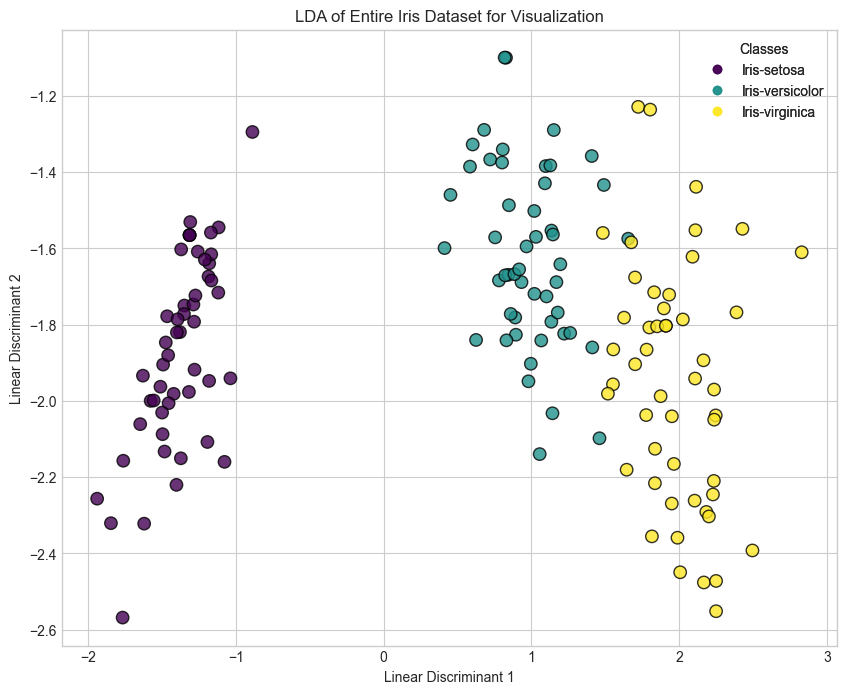

In [14]:
# Instantiate LDA to reduce to 2 components
lda = LDA(n_components=2)
# Project the entire dataset X
X_projected = lda.fit_transform(X, y)

print("Shape of original data:", X.shape)
print("Shape of projected data:", X_projected.shape)

# Plot the projected data
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    X_projected[:, 0],
    X_projected[:, 1],
    c=y,
    cmap='viridis',
    edgecolor='k',
    s=80,
    alpha=0.8
)

ax.set_xlabel('Linear Discriminant 1')
ax.set_ylabel('Linear Discriminant 2')
ax.set_title('LDA of Entire Iris Dataset for Visualization')
legend1 = ax.legend(handles=scatter.legend_elements()[0],
                    labels=list(class_names),
                    title="Classes")
ax.add_artist(legend1)
plt.show()

## Part 3: LDA for Classification and Evaluation 

Now we treat LDA as a preprocessing step in a proper machine learning pipeline. To evaluate performance fairly, we must split our data into training and testing sets. We will train a classifier **only on the training data** and evaluate it **on the unseen test data**.

### 3.1 Import Additional Libraries

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

### 3.2 Split Data into Training and Test Sets

We use the `X_projected` data from the previous step and split it into 80% for training and 20% for testing.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_projected, y, test_size=0.2, random_state=42, stratify=y
)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (120, 2)
Test data shape: (30, 2)


### 3.3 Train a Classifier and Make Predictions

In [17]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

### 3.4 Evaluate the Classifier

#### Confusion Matrix
The confusion matrix shows correct vs. incorrect predictions for each class on the **test set**.

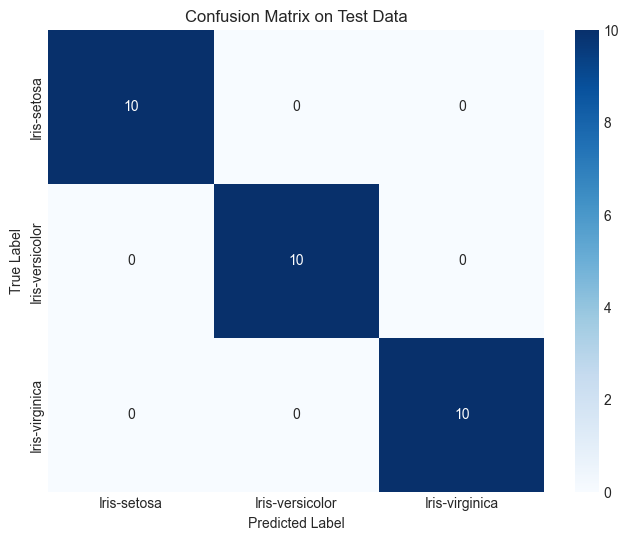

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data')
plt.show()

#### Classification Report
This report provides key metrics like precision, recall, and F1-score.

In [19]:
print("Classification Report on Test Data:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report on Test Data:

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



### 3.5 Visualize Test Set Results

This final plot shows the performance on the unseen test data. We highlight any misclassified points to see where the model failed.

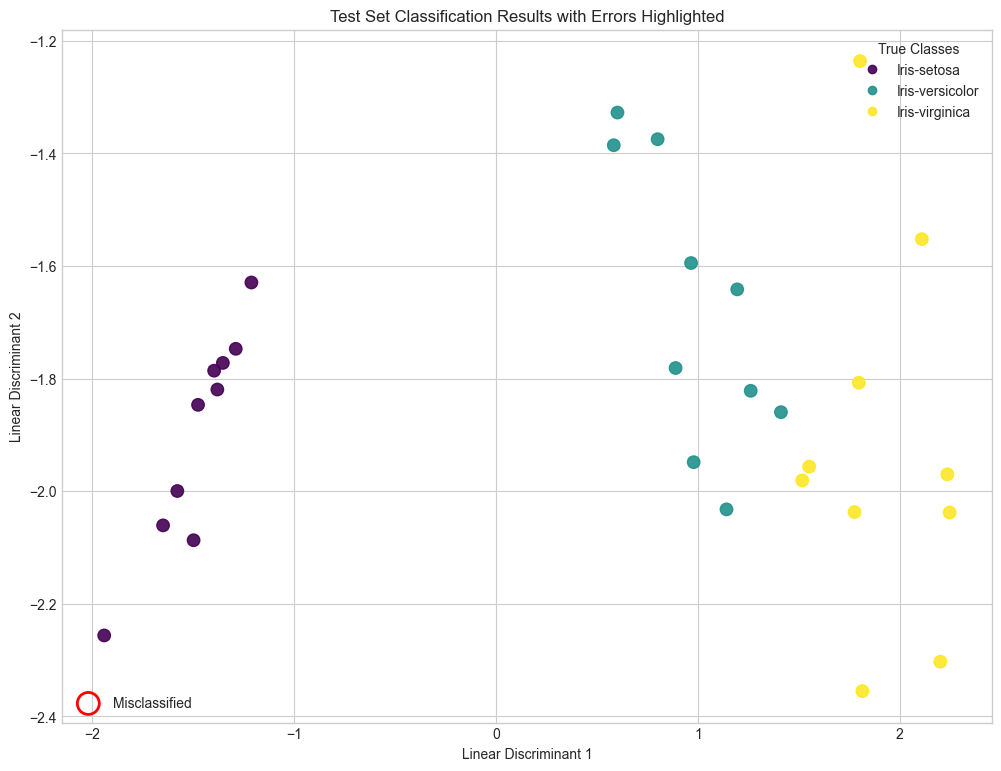

In [20]:
# Find misclassified samples
misclassified_idx = np.where(y_test != y_pred)[0]

# Plot the test set results
fig, ax = plt.subplots(figsize=(12, 9))

scatter = ax.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    cmap='viridis',
    s=80,
    alpha=0.9
)

ax.scatter(
    X_test[misclassified_idx, 0],
    X_test[misclassified_idx, 1],
    s=250, 
    facecolors='none', 
    edgecolors='red',
    linewidth=2,
    label='Misclassified'
)

ax.set_xlabel('Linear Discriminant 1')
ax.set_ylabel('Linear Discriminant 2')
ax.set_title('Test Set Classification Results with Errors Highlighted')

# Create two legends
class_legend = ax.legend(handles=scatter.legend_elements()[0],
                         labels=list(class_names),
                         title="True Classes",
                         loc='upper right')
ax.add_artist(class_legend)
ax.legend(loc='lower left')

plt.show()